In [1]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
df = pd.read_csv('hw2q1.csv')
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [3]:
X

,Pclass,Sex,Embarked,Fare
0,Upper,Male,Cherbourg,Expensive
1,Upper,Female,Cherbourg,Expensive
2,Middle,Female,Queenstown,Expensive
3,Upper,Female,Queenstown,Expensive
4,Lower,Female,Queenstown,Expensive
5,Middle,Male,Cherbourg,Expensive
6,Lower,Male,Queenstown,Cheap
7,Middle,Male,Queenstown,Expensive
8,Middle,Female,Cherbourg,Cheap
9,Upper,Male,Cherbourg,Expensive


In [4]:
from sklearn.preprocessing import LabelEncoder

In [5]:
for col in df.columns:
    le = LabelEncoder()
    le.fit(df[col])
    df[col] = le.transform(df[col])

In [6]:
df

,Pclass,Sex,Embarked,Fare,Survival
0,2,1,0,1,0
1,2,0,0,1,1
2,1,0,1,1,0
3,2,0,1,1,1
4,0,0,1,1,0
5,1,1,0,1,1
6,0,1,1,0,0
7,1,1,1,1,1
8,1,0,0,0,0
9,2,1,0,1,1


In [7]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [8]:
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X, y)

DecisionTreeClassifier(max_depth=3)

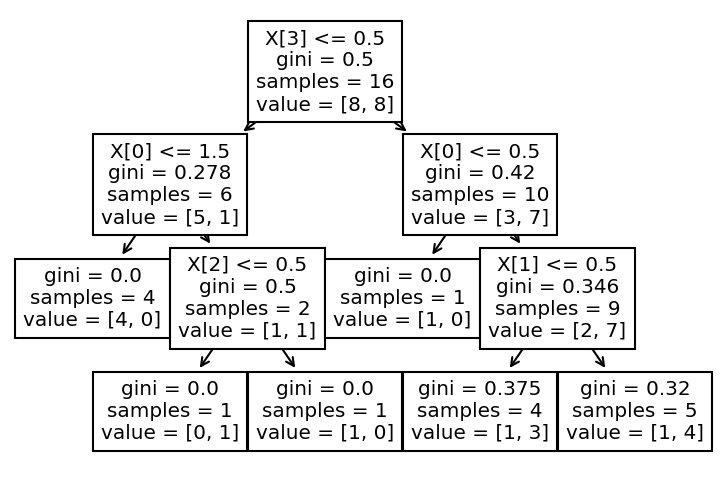

In [9]:
plt.figure(dpi=150)
plot_tree(tree);

In [10]:
tree.score(X, y)

0.875

In [11]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2)
tree.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

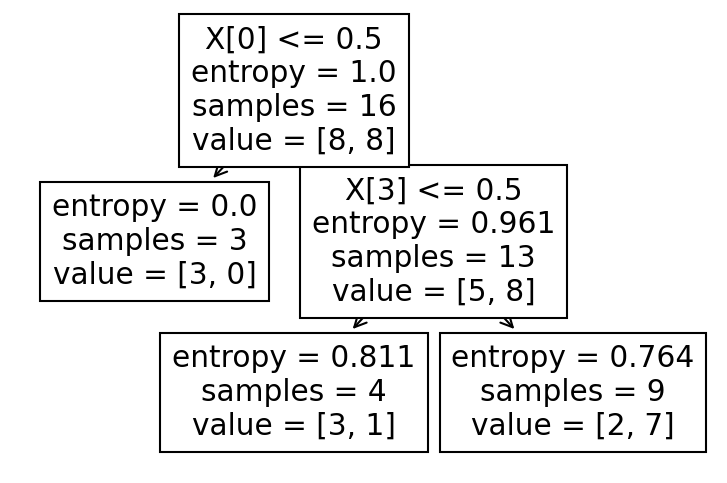

In [12]:
plt.figure(dpi=150)
plot_tree(tree);

In [13]:
tree.score(X, y)

0.8125

In [2]:
from collections import Counter

class Node:
    def __init__(self, data: pd.DataFrame, Y_attr: str, split_con='None'):
        """
        Creates a new Node instance.

        Args:
        -----
        data: The data to be contained in this node
        Y_attr: The string representing the Y attribute
        split_con: The attribute that this data was split on
        """
        self.data = data
        self.y_attr = Y_attr
        self.split_condition = split_con
        self.children = []
    
    def get_entropy(self, data: pd.DataFrame) -> float:
        """
        Gets the entropy of the data.

        Args:
        -----
        data: The data to find the entropy of
        """
        cnt = Counter(data[self.y_attr])
        probs = [x / len(data.index) for x in cnt.values()]
        return sum([-p * math.log(p, 2) for p in probs])
    
    def get_split_condition(self) -> tuple:
        """
        Returns the attribute, which on splitting by yields the highest
        information gain.
        """
        best_split = None
        info_gain = 0
        par_entropy = self.get_entropy(self.data)

        for col in self.data.columns:
            if col != self.y_attr:
                groups = list(self.data.groupby(col))
                for _, group in groups:
                    entropy = self.get_entropy(group)
                    cur_info_gain = par_entropy - len(group.index) / len(self.data.index) * entropy
                    if cur_info_gain > info_gain:
                        best_split = col
                        info_gain = cur_info_gain

        return best_split, info_gain
    
    def split(self, verbose=True) -> None:
        """
        Splits the data in the current node by the best split condition.

        Args:
        -----
        verbose: Prints debug information
        """
        split, info_gain = self.get_split_condition()
        
        if split is None:
            return

        if verbose:
            print('Splitting on', split, 'with information gain', info_gain)

        # Split the data by the condition
        groups = list(self.data.groupby(by=split))

        if verbose:
            print('Children:')

        for _, group in groups:
            # Remove the split condition column and create a node from the
            # resulting dataset
            group.drop(split, axis=1, inplace=True)

            if verbose:
                print()
                print(split, '=', _)
                print('---------\n', group)

            n = Node(group, self.y_attr, split)
            self.children.append(n)
    
class DecisionTree(Node):
    """
    A DecisionTree class that implements the ID3 algorithm using the Node
    class.	
    """
    def __init__(self, data: pd.DataFrame, y: str):
        """
        Creates a DecisionTree object.

        Args:
        -----
        data: The data for the current node
        y: The output attribute
        """
        super().__init__(data, y)
        
    def fit(self) -> None:
        """
        Creates the full decision tree from the current data.
        """
        stack = [self]

        while len(stack) > 0:
            node = stack.pop()

            # If entropy is 0, then stop splitting.
            if node.get_entropy(node.data) > 0:
                node.split(verbose=True)
                for child in node.children:
                    stack.append(child)
    
    def predict(self, sample: pd.DataFrame) -> str:
        """
        Returns the class label for the given sample.

        Args:
        -----
        sample: A DataFrame containing a single sample to predict on
        """
        node = self

        # Guess randomly if looping infinitely
        it_counter = 0

        while len(node.children) > 0:
            # Get the current splitting condition.
            split_con = node.children[0].split_condition

            for child in node.children:
                data = child.data

                # Get the first sample in this split
                first_sample = list(data.index)[0]

                # Check if this child has the right value of the splitting
                # condition. If not, try another child.
                it_counter += 1
                if sample[split_con][0] == node.data.loc[first_sample,:][split_con]:
                    node = child
                    it_counter = 0
                    break

                if it_counter == 2:
                    global guess_count
                    guess_count += 1
                    it_counter = 0
                    print('Random guess', guess_count)
                    y_uniq = np.unique(node.data[self.y_attr])
                    return random.choice(y_uniq)

        return list(node.data[self.y_attr])[0]

In [54]:
root = DecisionTree(df, y='Survival')

In [55]:
root.fit()

Splitting on Pclass with information gain 1.0
Children:

Pclass = Lower
---------
        Sex    Embarked       Fare Survival
4   Female  Queenstown  Expensive        F
6     Male  Queenstown      Cheap        F
14    Male  Queenstown      Cheap        F

Pclass = Middle
---------
        Sex    Embarked       Fare Survival
2   Female  Queenstown  Expensive        F
5     Male   Cherbourg  Expensive        T
7     Male  Queenstown  Expensive        T
8   Female   Cherbourg      Cheap        F
11  Female  Queenstown  Expensive        T
13    Male   Cherbourg      Cheap        F

Pclass = Upper
---------
        Sex    Embarked       Fare Survival
0     Male   Cherbourg  Expensive        F
1   Female   Cherbourg  Expensive        T
3   Female  Queenstown  Expensive        T
9     Male   Cherbourg  Expensive        T
10    Male   Cherbourg  Expensive        T
12    Male  Queenstown      Cheap        F
15    Male   Cherbourg      Cheap        T
Splitting on Sex with information gain 0.8631

In [29]:
import gc

In [30]:
del DecisionTree, Node, root
gc.collect()

8170

## Entire calculation

In [10]:
import numpy as np

In [3]:
df = pd.read_csv('hw2q1.csv')

In [4]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

In [13]:
def gini_impurity(probs):
    return 1 - sum([p ** 2 for p in probs])

In [30]:
def gini_index(df, column):
    # Generate the table
    groups = df.groupby(by=column)
    total_len = len(df)
    impurities = []
    sizes = []
    for _, group in groups:
        probs = [sum(group['Survival'] == 'T') / len(group.index), 
                 sum(group['Survival'] == 'F') / len(group.index)]
        impurities.append(gini_impurity(probs))
        sizes.append(len(group.index) * 1. / total_len)
    
    print(impurities, sizes)
    return np.dot(impurities, sizes)

In [31]:
gini_index(df, 'Sex')

[0.5, 0.5] [0.375, 0.625]


0.5

In [32]:
for col in df.columns[:-1]:
    print(col, '-', gini_index(df, col))

[0.0, 0.5, 0.40816326530612246] [0.1875, 0.375, 0.4375]
Pclass - 0.3660714285714286
[0.5, 0.5] [0.375, 0.625]
Sex - 0.5
[0.46875, 0.46875] [0.5, 0.5]
Embarked - 0.46875
[0.2777777777777777, 0.42000000000000004] [0.375, 0.625]
Fare - 0.36666666666666664


In [36]:
d = df[df['Fare'] == 'Upper']
for col in d.columns[:-1]:
    print(col, '-', gini_index(d, col))

[0.40816326530612246] [1.0]
Pclass - 0.40816326530612246
[0.0, 0.48] [0.2857142857142857, 0.7142857142857143]
Sex - 0.34285714285714286
[0.31999999999999984, 0.5] [0.7142857142857143, 0.2857142857142857]
Embarked - 0.37142857142857133
[0.5, 0.31999999999999984] [0.2857142857142857, 0.7142857142857143]
Fare - 0.37142857142857133
